<a href="https://colab.research.google.com/github/shinjinigupta/Smart_City_Crime_Watch/blob/main/Fight_Action.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fight Action Recognition

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155113 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

#### Importing the required libaries

In [2]:
# Discard the output of this cell.
%%capture

# Install the required libraries.
!pip install youtube-dl moviepy
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [3]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3448832/45929032 bytes (7.5%)6119424/45929032 bytes (13.3%)9216000/45929032 bytes (20.1%)12877824/45929032 bytes (28.0%)16285696/45929032 bytes (35.5%)19210240/45929032 bytes (41.8%)22085632/45929032 bytes (48.1%)25690112/45929032 bytes (55.9%)28606464/45929032 bytes (62.3%)31776768/45929032 bytes (69.2%)35037184/45929032 bytes (76.3%)38625280/45929032 bytes (84.1%)

#### Fetching the Dataset

In [4]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Locating the datasets in google drive
fight_data = os.listdir('/content/drive/MyDrive/Colab Notebooks/Final_Proj/Dataset_fight/fight')
nofight_data=os.listdir('/content/drive/MyDrive/Colab Notebooks/Final_Proj/Dataset_fight/noFight')



count_fight=len(fight_data)
print("Count of fight data:",count_fight)

count_nofight=len(nofight_data)
print("Count of no fight data:",count_nofight)

Count of fight data: 100
Count of no fight data: 101


<Figure size 1440x1440 with 0 Axes>

##### Displaying a randomly selected fight data video frame with its label

Fight filename:newfi5.avi


(-0.5, 719.5, 575.5, -0.5)

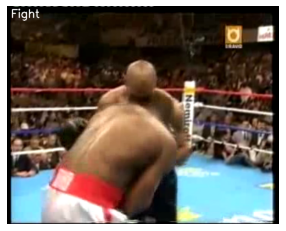

In [5]:
# Randomly selecting a video file from the fight data to display its frame with label
selected_fight_data = random.choice(fight_data)
print("Fight filename:"+ selected_fight_data)

# Initializing a VideoCapture object to read from the video File.
fight_url = '/content/drive/MyDrive/Colab Notebooks/Final_Proj/Dataset_fight/fight'
video_reader = cv2.VideoCapture(f'{fight_url}/{selected_fight_data}')

# Reading the first frame of the video file.
_, bgr_frame = video_reader.read()

# Releasing the VideoCapture object. 
video_reader.release()

# Convert the frame from BGR into RGB format. 
rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

# Write the class name on the video frame.
fight_frame=cv2.putText(rgb_frame, 'Fight', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# Display the frame.

plt.imshow(fight_frame);plt.axis('off')


##### Displaying a randomly selected non fight data video frame with its label

Fight filename:53.mpg


(-0.5, 719.5, 479.5, -0.5)

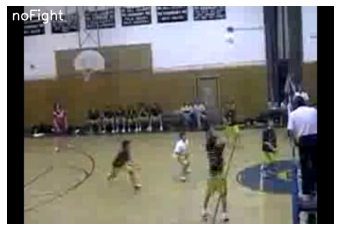

In [6]:
# Randomly selecting a video file from the nofight data to display its frame with label
selected_nofight_data = random.choice(nofight_data)
print("Fight filename:"+ selected_nofight_data)

# Initializing a VideoCapture object to read from the video File.
nofight_url = '/content/drive/MyDrive/Colab Notebooks/Final_Proj/Dataset_fight/noFight'
video_reader = cv2.VideoCapture(f'{nofight_url}/{selected_nofight_data}')

# Reading the first frame of the video file.
_, bgr_frame = video_reader.read()

# Releasing the VideoCapture object. 
video_reader.release()

# Convert the frame from BGR into RGB format. 
rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

# Write the class name on the video frame.
nofight_frame=cv2.putText(rgb_frame, 'noFight', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# Display the frame.

plt.imshow(nofight_frame);plt.axis('off')

#### Preprocessing the data

In [7]:
# Specifying the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 200, 200

# Specifying the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 15

# Specifying the directory containing the fight action dataset. 
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/Final_Proj/Dataset_fight"

# Specifying the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["fight", "nofight"]

##### Creating a function to extract, resize and normalize the video frames

In [8]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

##### Creating a function for dataset creation by extracting frames from the videos

In [9]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

##### Calling the function to create the dataset to train our model.

In [13]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: fight
Extracting Data of Class: nofight


In [14]:
# creating pickle file to save the extracted features
import pickle
import os

'''pickle.dump(features,open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/fight_features.dat","wb"), protocol=4)
pickle.dump(labels,open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/fight_labels.dat","wb"), protocol=4)
pickle.dump(video_files_paths,open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/fight_video_files_paths.dat","wb"), protocol=4)'''

pickle.dump(features,open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/peliculas_fight_features.dat","wb"), protocol=4)
pickle.dump(labels,open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/peliculas_fight_labels.dat","wb"), protocol=4)
pickle.dump(video_files_paths,open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/peliculas_fight_video_files_paths.dat","wb"), protocol=4)

In [10]:
# loading the features from the saved pickle file
import pickle
import os

'''features=pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/fight_features.dat","rb"))
labels=pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/fight_labels.dat","rb"))
video_files_paths=pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/fight_video_files_paths.dat","rb"))'''

features=pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/peliculas_fight_features.dat","rb"))
labels=pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/peliculas_fight_labels.dat","rb"))
video_files_paths=pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/peliculas_fight_video_files_paths.dat","rb"))

##### Converting labels (class indexes) into one-hot encoded vectors.

In [11]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors

from tensorflow.keras.utils import to_categorical
one_hot_encoded_labels = to_categorical(labels)

#### Creating the train and test datasets

In [12]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).

from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            )

In [18]:
labels_test

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

#### Creating the LRCN model with pretrained inception V3 & LSTM

In [13]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras import optimizers
from tensorflow import keras
import tensorflow as tf
 
from keras.applications.resnet_v2 import ResNet50V2
from keras.layers import Dense, LSTM,  Flatten, TimeDistributed, Conv2D, Dropout
from keras import Sequential
from keras.models import Model


In [14]:
inceptionv3_model=keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        #pooling="avg",
        input_shape=(IMAGE_HEIGHT , IMAGE_WIDTH, 3),
    )


'''for layer in inceptionv3_model.layers[:249]:
    layer.trainable = False
for layer in inceptionv3_model.layers[249:]:
    layer.trainable = True

for layer in inceptionv3_model.layers:
  #sp='  '[len(layer.name)]
  print(layer.name,layer.trainable)'''

87924736/87910968 [==============================] - 0s 0us/step


"for layer in inceptionv3_model.layers[:249]:\n    layer.trainable = False\nfor layer in inceptionv3_model.layers[249:]:\n    layer.trainable = True\n\nfor layer in inceptionv3_model.layers:\n  #sp='  '[len(layer.name)]\n  print(layer.name,layer.trainable)"

In [15]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
    '''inceptionv3_model=keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMAGE_HEIGHT , IMAGE_WIDTH, 3),
    )'''
    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    
    model.add(TimeDistributed(inceptionv3_model,
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
                                      
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(256, activation='relu', return_sequences=False))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(len(CLASSES_LIST), activation = 'sigmoid'))


    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

#### LRCN model with CNN

In [1]:
def create_LRCN_model_CNN():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

#### LRCN model with ResNet50V2

In [15]:
ResNet50V2 = ResNet50V2(
    include_top=False,
    weights='imagenet',
    #input_shape=(224, 224, 3)
    input_shape=(IMAGE_HEIGHT , IMAGE_WIDTH, 3)
)
# do not train first layers, I want to only train
# the 4 last layers 
for layer in ResNet50V2.layers[:-4]:
    layer.trainable = False# create a Sequential model
model = Sequential()# add vgg model for 10 input images (keeping the right shape
model.add( TimeDistributed(ResNet50V2, input_shape=(10, 224, 224, 3)))# now, flatten on each output to send 5 
# outputs with one dimension to LSTM
model.add(
    TimeDistributed(
        Flatten()
    )
)
model.add(LSTM(256, activation='relu', return_sequences=False))# finalize with standard Dense, Dropout...
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2, activation='sigmoid'))
model.compile('adam', loss='binary_crossentropy', metrics=["accuracy"])

convlstm_model_training_history=model.fit(features_train, labels_train, batch_size=20, epochs=20, validation_data=(features_test, labels_test), verbose=1)

94683136/94668760 [==============================] - 1s 0us/step
Epoch 1/20
11/11 [==============================] - 26s 1s/step - loss: 35.3039 - accuracy: 0.5524 - val_loss: 32.6044 - val_accuracy: 0.5889
Epoch 2/20
11/11 [==============================] - 8s 742ms/step - loss: 38.8835 - accuracy: 0.5429 - val_loss: 28.6419 - val_accuracy: 0.6889
Epoch 3/20
11/11 [==============================] - 8s 741ms/step - loss: 32.6651 - accuracy: 0.6238 - val_loss: 33.4098 - val_accuracy: 0.5667
Epoch 4/20
11/11 [==============================] - 8s 741ms/step - loss: 23.6989 - accuracy: 0.6429 - val_loss: 42.4664 - val_accuracy: 0.5889
Epoch 5/20
11/11 [==============================] - 8s 741ms/step - loss: 22.8157 - accuracy: 0.7000 - val_loss: 27.0215 - val_accuracy: 0.5333
Epoch 6/20
11/11 [==============================] - 8s 741ms/step - loss: 26.5068 - accuracy: 0.6381 - val_loss: 36.1845 - val_accuracy: 0.5222
Epoch 7/20
11/11 [==============================] - 8s 741ms/step - loss:

#### Creating our LRCN model

In [16]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 4, 4, 2048)   21802784  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 32768)        0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 256)               33817600  
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1

#### Checking model structure

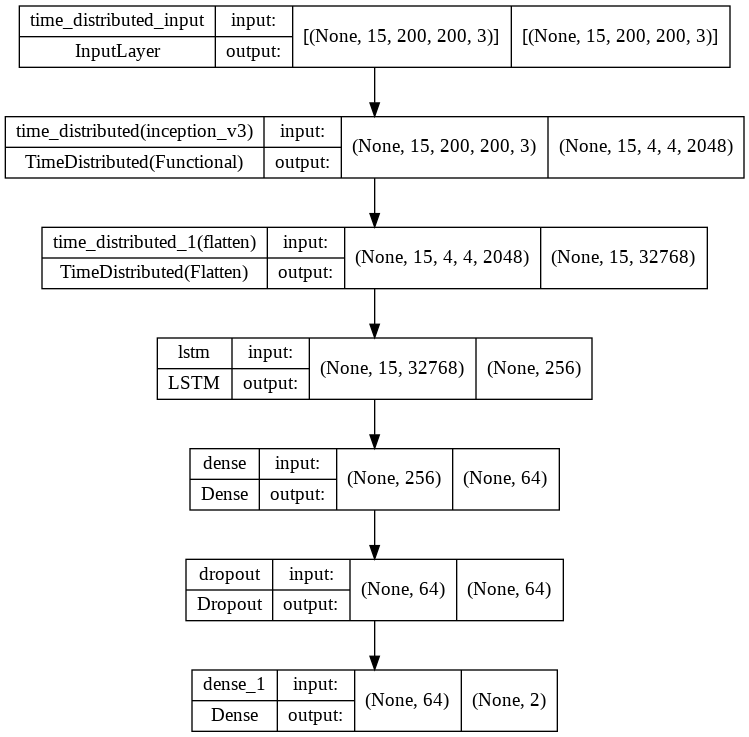

In [17]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

#### Compiling &training the model

In [18]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2,callbacks = [early_stopping_callback])
#LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , validation_data = (features_test, labels_test))

Epoch 1/50
30/30 [==============================] - 31s 413ms/step - loss: 113.9528 - accuracy: 0.5417 - val_loss: 210.0569 - val_accuracy: 0.5333
Epoch 2/50
30/30 [==============================] - 9s 310ms/step - loss: 58.4982 - accuracy: 0.5750 - val_loss: 28.5779 - val_accuracy: 0.7333
Epoch 3/50
30/30 [==============================] - 9s 307ms/step - loss: 26.2388 - accuracy: 0.7083 - val_loss: 17.3967 - val_accuracy: 0.7667
Epoch 4/50
30/30 [==============================] - 9s 308ms/step - loss: 19.5144 - accuracy: 0.7000 - val_loss: 13.9431 - val_accuracy: 0.6667
Epoch 5/50
30/30 [==============================] - 9s 301ms/step - loss: 35.2914 - accuracy: 0.6833 - val_loss: 47.9552 - val_accuracy: 0.7333
Epoch 6/50
30/30 [==============================] - 9s 302ms/step - loss: 24.1757 - accuracy: 0.5917 - val_loss: 21.4463 - val_accuracy: 0.7333
Epoch 7/50
30/30 [==============================] - 9s 308ms/step - loss: 11.8590 - accuracy: 0.6833 - val_loss: 6.3866 - val_accurac

In [19]:
#Testing the accuracy on test data

test_prediction = LRCN_model.evaluate(features_test, labels_test, verbose=1)
#test_prediction = model.evaluate(features_test, labels_test, verbose=1)

print("Accuracy: %.2f%%" % (test_prediction[1]*100))
print("Loss: %.2f%%" %((test_prediction[0]*100)))

2/2 [==============================] - 4s 2s/step - loss: 0.3187 - accuracy: 0.8627
Accuracy: 86.27%
Loss: 31.87%


#### Saving the model

In [20]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = test_prediction

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
#model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'/content/drive/MyDrive/Colab Notebooks/Final_Proj/InceptionV3_best_model_Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)
#pickle.dump(best_model,open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/best_model.dat","wb"), protocol=4)

#LRCN_model=pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Final_Proj/best_model.dat","rb"))


#### Plotting Model’s Loss & Accuracy Curves

In [21]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

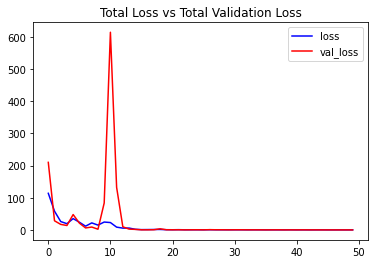

In [22]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

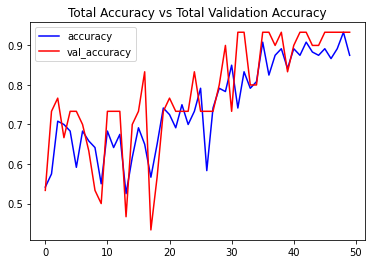

In [23]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

#### Creating a Function to Download YouTube Videos

In [31]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''
 
     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)
 
     # Retrieve the title of the video.
     title = video.title
 
     # Get the best available quality object for the video.
     video_best = video.getbest()
 
     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'
 
     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)
 
     # Return the video title.
     return title

#### Downloading a Test Video

In [32]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=y8Ye7z26Q-s', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

ERROR: Sign in to confirm your age
This video may be inappropriate for some users.


OSError: ignored

In [33]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read() 

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    # Release the VideoCapture object. 
    video_reader.release()

In [43]:
# Download the youtube video.
#video_title = download_youtube_videos('https://youtu.be/fc3w827kwyA', test_videos_directory)

# Construct the input youtube video path
#input_video_file_path = f'/content/drive/MyDrive/Colab Notebooks/Final_Proj/Dataset_fight1/noFight/nofi006.mp4'
input_video_file_path = f'/content/drive/MyDrive/Colab Notebooks/Final_Proj/Dataset_fight1/fight/fi026.mp4'
# Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

# Display the input video.
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

Action Predicted: fight
Confidence: 0.7184774875640869


100%|██████████| 69/69 [00:00<00:00, 519.68it/s]


#### Predicting on test video

In [26]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [39]:
# Construct the output video path.
output_video_file_path = f'/content/drive/MyDrive/Colab Notebooks/Final_Proj/Dataset_fight1/test_videos-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

input_video_file_path = f'/content/drive/MyDrive/Colab Notebooks/Final_Proj/Test_vdos/3.mp4'
#input_video_file_path = f'/content/drive/MyDrive/Colab Notebooks/Final_Proj/Dataset_fight1/noFight/nofi055.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|█████████▉| 1440/1441 [00:04<00:00, 324.00it/s]
